<a href="https://colab.research.google.com/github/othmane42/defi1_hackAI/blob/main/D%C3%A9fis2_submission_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install -q transformers  datasets  sentencepiece sacremoses

     |████████████████████████████████| 880 kB 5.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 0.6. Importation de librairies utiles

In [ ]:
import os
import numpy as np
import pandas as pd
from transformers import TrainingArguments, Trainer
from transformers import CamembertForSequenceClassification, FlaubertForSequenceClassification, CamembertTokenizer , FlaubertTokenizer
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score

np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan', precision=3, suppress=False, threshold=1000, formatter=None)

# 1. Chargement de la base de données

## 1.1. Chargement pour sklearn

Le bout de code suivant montre comment charger le dataset du challenge pour sklearn. Le corpus se trouve donc dans la variable *ds_train['data']* et les labels dans *ds_train['label']*.

In [ ]:
ROOTDIR = "/content/drive/MyDrive/MyDataset/Defi2Dataset"

In [ ]:
ds_train = pd.read_csv(os.path.join(ROOTDIR,'fake_train.csv') )
ds_test = pd.read_csv(os.path.join(ROOTDIR,'fake_test.csv'))

print("Nombre de news")
print(len(ds_train))
print("")
print("Affichage de la 1ère news")
print(ds_train['data'][0])
print("")
print("Label de la 1ère news")
print(ds_train['label'][0])

Nombre de news
1458

Affichage de la 1ère news
Au 22e jour consécutif de la grève reconductible contre la réforme des retraites (soit autant de jours que le long conflit de 1995), le taux de grévistes à la SNCF a légèrement baissé à 9,6 % jeudi matin, contre 9,8 % mardi, selon la direction du groupe public. Parmi les personnels indispensables à la circulation des trains, moins de la moitié des conducteurs (42,1 %) et le quart (24 %) des contrôleurs étaient grévistes, des taux en recul par rapport à mardi (49,3 % chez les conducteurs), jour du réveillon de Noël et précédent jour de publication de ces taux. Le taux des aiguilleurs en grève a légèrement augmenté, à 13,8 %.

Label de la 1ère news
0


In [ ]:
ds_train.rename(columns={"label":"labels"},inplace=True)
ds_test.rename(columns={"label":"labels"},inplace=True)
ds_train.drop(columns=["Unnamed: 0"],inplace=True)
ds_test.drop(columns=["Unnamed: 0"],inplace=True)



In [ ]:
ds_train.target_name.unique()

array(['News', 'Fake News'], dtype=object)

In [ ]:
ds_train.head()

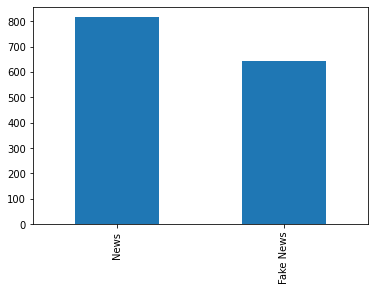

In [ ]:
ds_train.target_name.value_counts().plot(kind="bar")

In [ ]:
ds_train.to_csv("fake_train_.csv",index=False)
ds_test.to_csv("fake_test_.csv",index=False)

# 1.2. Pipeline 1(first approach ) Chargement pour les transformers de Huggingface

mddel used:Camembert , for more inspiration : (https://ledatascientist.com/analyse-de-sentiments-avec-camembert/)

In [ ]:
dataset_train = load_dataset("csv", data_files="fake_train_.csv", split='train')
dataset_test = load_dataset("csv", data_files="fake_test_.csv")

print("Nombre de news")
print(len(dataset_train))
print("")
print("Affichage de la 1ère news")
print(dataset_train[0])
print("")
print("Contenu de la 1ère news")
print(dataset_train[0]['data'])
print("")
print("Label de la 1ère news")
print("{} => {}".format(dataset_train[0]['labels'], dataset_train[0]['target_name']))
print("")

print("Affichage de la dernière news")
print(dataset_train[-1])
print("")
print("Contenu de la dernière news")
print(dataset_train[-1]['data'])
print("")
print("Label de la dernière news")
print("{} => {}".format(dataset_train[-1]['labels'], dataset_train[-1]['target_name']))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-78d6c1c51c4964da/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8ae5ff4bf9d2b90d/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Nombre de news
1458

Affichage de la 1ère news
{'data': 'Au 22e jour consécutif de la grève reconductible contre la réforme des retraites (soit autant de jours que le long conflit de 1995), le taux de grévistes à la SNCF a légèrement baissé à 9,6 % jeudi matin, contre 9,8 % mardi, selon la direction du groupe public. Parmi les personnels indispensables à la circulation des trains, moins de la moitié des conducteurs (42,1 %) et le quart (24 %) des contrôleurs étaient grévistes, des taux en recul par rapport à mardi (49,3 % chez les conducteurs), jour du réveillon de Noël et précédent jour de publication de ces taux. Le taux des aiguilleurs en grève a légèrement augmenté, à 13,8 %.', 'labels': 0, 'target_name': 'News'}

Contenu de la 1ère news
Au 22e jour consécutif de la grève reconductible contre la réforme des retraites (soit autant de jours que le long conflit de 1995), le taux de grévistes à la SNCF a légèrement baissé à 9,6 % jeudi matin, contre 9,8 % mardi, selon la direction du g

In [ ]:
dataset_test

DatasetDict({
    train: Dataset({
        features: ['data', 'labels', 'target_name'],
        num_rows: 486
    })
})

In [ ]:
train_val_dataset=dataset_train.train_test_split(test_size=0.2,seed=42)

In [ ]:
# You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
camembert = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels = 2)


def preprocess_function(examples):
    return tokenizer(examples['data'], truncation=True)

tokenized_hugging_train = train_val_dataset["train"].map(preprocess_function, batched=True,batch_size=8)
tokenized_hugging_val = train_val_dataset["test"].map(preprocess_function, batched=True,batch_size=8)
tokenized_hugging_test = dataset_test["train"].map(preprocess_function, batched=True,batch_size=8)


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

  0%|          | 0/146 [00:00<?, ?ba/s]

  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/61 [00:00<?, ?ba/s]

In [ ]:
categories = ['News', 'Fake News']
def map_label(sample):
  ind = categories.index(sample['target_name'])
  sample['labels'] = ind
  return sample

tokenized_hugging_train = tokenized_hugging_train.map(map_label, batched=False)
tokenized_hugging_test = tokenized_hugging_test.map(map_label, batched=False)
tokenized_hugging_val = tokenized_hugging_val.map(map_label, batched=False)


  0%|          | 0/1166 [00:00<?, ?ex/s]

  0%|          | 0/486 [00:00<?, ?ex/s]

  0%|          | 0/292 [00:00<?, ?ex/s]

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(-1)
    f1 = f1_score(labels, predictions)
    return {'f1': f1}


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    output_dir="./content/drive/MyDrive/MyModels/results_camamembert",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    metric_for_best_model="f1",
    save_strategy="epoch", # on enregistre le modèle à chaque epoch
    evaluation_strategy="epoch", # on évalue le modèle à chaque epoch
    load_best_model_at_end=True # on charge le meilleur modèle (en terme d'accuracy) à la fin de l'entrainement
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=camembert,
    args=training_args,
    train_dataset=tokenized_hugging_train,
    eval_dataset=tokenized_hugging_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `CamembertForSequenceClassification.forward` and have been ignored: target_name, data. If target_name, data are not expected by `CamembertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1166
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1460
  Number of trainable parameters = 110623490


Epoch,Training Loss,Validation Loss,F1
1,No log,0.032371,0.991736
2,No log,0.026353,0.991667
3,No log,0.085517,0.983193
4,0.056300,0.040063,0.991667
5,0.056300,0.047586,0.991667
6,0.056300,0.050955,0.991667
7,0.000700,0.052489,0.991667
8,0.000700,0.053965,0.991667
9,0.000700,0.054888,0.991667
10,0.000700,0.055252,0.991667


The following columns in the evaluation set don't have a corresponding argument in `CamembertForSequenceClassification.forward` and have been ignored: target_name, data. If target_name, data are not expected by `CamembertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 8
Saving model checkpoint to ./content/drive/MyDrive/MyModels/results_camamembert/checkpoint-146
Configuration saved in ./content/drive/MyDrive/MyModels/results_camamembert/checkpoint-146/config.json
Model weights saved in ./content/drive/MyDrive/MyModels/results_camamembert/checkpoint-146/pytorch_model.bin
tokenizer config file saved in ./content/drive/MyDrive/MyModels/results_camamembert/checkpoint-146/tokenizer_config.json
Special tokens file saved in ./content/drive/MyDrive/MyModels/results_camamembert/checkpoint-146/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `Came

TrainOutput(global_step=1460, training_loss=0.019645144157621957, metrics={'train_runtime': 1235.5983, 'train_samples_per_second': 9.437, 'train_steps_per_second': 1.182, 'total_flos': 3061728795688800.0, 'train_loss': 0.019645144157621957, 'epoch': 10.0})

In [ ]:
trainer.evaluate(eval_dataset=tokenized_hugging_test)

The following columns in the evaluation set don't have a corresponding argument in `CamembertForSequenceClassification.forward` and have been ignored: target_name, data. If target_name, data are not expected by `CamembertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 486
  Batch size = 8


{'eval_loss': 0.11775372177362442,
 'eval_f1': 0.9739952718676123,
 'eval_runtime': 13.0473,
 'eval_samples_per_second': 37.249,
 'eval_steps_per_second': 4.675,
 'epoch': 10.0}

# pipeline 3 :  flaubert

In [ ]:
tokenizer = FlaubertTokenizer.from_pretrained("flaubert/flaubert_base_cased")
flautbert = FlaubertForSequenceClassification.from_pretrained(
        "flaubert/flaubert_base_cased",
        num_labels=2)

def preprocess_function(examples):
    return tokenizer(examples['data'], truncation=True)

tokenized_hugging_train = train_val_dataset["train"].map(preprocess_function, batched=True,batch_size=8)
tokenized_hugging_val = train_val_dataset["test"].map(preprocess_function, batched=True,batch_size=8)
tokenized_hugging_test = dataset_test["train"].map(preprocess_function, batched=True,batch_size=8)


Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertForSequenceClassification: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

  0%|          | 0/146 [00:00<?, ?ba/s]

  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/61 [00:00<?, ?ba/s]

In [ ]:
categories = ['News', 'Fake News']
def map_label(sample):
  ind = categories.index(sample['target_name'])
  sample['labels'] = ind
  return sample

tokenized_hugging_train = tokenized_hugging_train.map(map_label, batched=False)
tokenized_hugging_test = tokenized_hugging_test.map(map_label, batched=False)
tokenized_hugging_val = tokenized_hugging_val.map(map_label, batched=False)


  0%|          | 0/1166 [00:00<?, ?ex/s]

  0%|          | 0/486 [00:00<?, ?ex/s]

  0%|          | 0/292 [00:00<?, ?ex/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    output_dir="./content/drive/MyDrive/MyModels/results_flaubert",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    metric_for_best_model="f1",
    save_strategy="epoch", # on enregistre le modèle à chaque epoch
    evaluation_strategy="epoch", # on évalue le modèle à chaque epoch
    load_best_model_at_end=True # on charge le meilleur modèle (en terme d'accuracy) à la fin de l'entrainement
)

In [ ]:
trainer = Trainer(
    model=flautbert,
    args=training_args,
    train_dataset=tokenized_hugging_train,
    eval_dataset=tokenized_hugging_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: target_name, data. If target_name, data are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1166
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1460
  Number of trainable parameters = 138234626


Epoch,Training Loss,Validation Loss,F1
1,No log,0.252975,0.938596
2,No log,0.170655,0.943723
3,No log,0.145359,0.966102
4,0.211300,0.138396,0.979079
5,0.211300,0.128531,0.975000
6,0.211300,0.111630,0.979253
7,0.025500,0.149266,0.975000
8,0.025500,0.152646,0.975000
9,0.025500,0.152335,0.975000
10,0.025500,0.152080,0.975000


The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: target_name, data. If target_name, data are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 8
Saving model checkpoint to ./content/drive/MyDrive/MyModels/results_flaubert/checkpoint-146
Configuration saved in ./content/drive/MyDrive/MyModels/results_flaubert/checkpoint-146/config.json
Model weights saved in ./content/drive/MyDrive/MyModels/results_flaubert/checkpoint-146/pytorch_model.bin
tokenizer config file saved in ./content/drive/MyDrive/MyModels/results_flaubert/checkpoint-146/tokenizer_config.json
Special tokens file saved in ./content/drive/MyDrive/MyModels/results_flaubert/checkpoint-146/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceCl

TrainOutput(global_step=1460, training_loss=0.08130590180828147, metrics={'train_runtime': 1360.485, 'train_samples_per_second': 8.57, 'train_steps_per_second': 1.073, 'total_flos': 3037407403821216.0, 'train_loss': 0.08130590180828147, 'epoch': 10.0})

In [ ]:
trainer.evaluate(eval_dataset=tokenized_hugging_test)

The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: target_name, data. If target_name, data are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 486
  Batch size = 8


{'eval_loss': 0.2192670851945877,
 'eval_f1': 0.9617224880382776,
 'eval_runtime': 14.3646,
 'eval_samples_per_second': 33.833,
 'eval_steps_per_second': 4.247,
 'epoch': 10.0}

# pipeline 2 (second approach )  ML model with tf-idf tokenizers 

model used ( comparision using pycaret)